# Voice Identification

### n-shot learning

The idea of one shot learning is to train an algorithm so that after only `n` examples, an algorithm can identify a example again. 

Siamese networks attempt to do this by training a model to learn how to take a high dimensional input an generate a feature vector. The network is trained by taking two examples either similar or different and training them to reduce/increase the distance of the feature vector generated by the output.

### Applying to Voice Identification

The end goal of this model is to take a audio sample that has undergone speech diarihsation and identify each speaker in the set.

### Datasets

| Name | Speakers           | Min  | Max
| ------------- |-------------|-----|-----|
[VoxCeleb](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/)| 7000+| 3s | 3s
[10 English Speakers](http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS) | 10 | ? | ? 

### Articles

- https://github.com/zdmc23/oneshot-audio/blob/master/OneShot.ipynb

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.debugger import set_trace

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *
from torch import nn
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataAugmentation import *

## 10 Speakers

Lets get a feel for the architecture by creating it and training on a dataset that we know we can do well on using standard classification techiques

In [3]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest=data_folder)

PosixPath('/home/h/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [4]:
max_length = 4*16000 
tfm_params = {
    'max_to_pad':max_length,
    'use_spectro':True, 
    'cache_spectro':True, 
    'to_db_scale':True,
    'f_max': 120
}
label_pattern = r'_([mf]\d+)_'
audios = AudioList.from_folder(data_folder, **tfm_params).split_none().label_from_re(label_pattern)
audios.train.x.tfm_args = tfm_params
audios.valid.x.tfm_args = tfm_params

## Loss functions 

In [5]:
def loss_max_sig(i, t): return nn.Sigmoid(-torch.sqrt(mse(i,t)))
def loss_min_sig(i ,t): return nn.Sigmoid(torch.sqrt(mse(i,t)))

In [6]:
class SiameseResnet(nn.Module):
    def __init__(self, encoder=models.resnet18):
        super().__init__()
        
        newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
        ## Standard learner
        learn = cnn_learner(data, models.resnet18, metrics=accuracy)
        ## Replace the first layer in the resnet18 model with our first layer
        
        self.body = create_body(encoder, cut=-2)
        self.body[0]= newlayer
        self.head = create_head(2048, 1, [512])
        
    def forward(self, x1, x2):
        out1 = self.body(x1)
        out2 = self.body(x2)
        out = torch.cat((out1, out2), dim=1)
        out = self.head(out)
        return out.view(-1)

In [7]:
class ItemTuple(ItemBase):
    
    def replace_meth(self, meth):
        # Replace the method with an interable version
        pass
    
    def __init__(self, items):
        self.size = len(items)
        self.items = items
        eg = items[0]
        self.apply_tfms = eg.apply_tfms
        self.__repr__ = eg.__repr__
        self.data = [x.data for x in items]
    
    def show(self):
        [x.show() for x in self.items]
    
    def __repr__(self):
        return ''.join([str(x) for x in self.items]) + '\n'
    
    def __len__(self):
        return self.size

In [8]:
class SiameseList(ItemList):
    
    def __init__(self, *args, open_fn=lambda x:x, open_args={}, **kwargs):
        super().__init__(*args, **kwargs)
        self.open = open_fn
        self.open_args = open_args
        
    def get(self, i):
        return ItemTuple([self.open(x, **self.open_args) for x in super().get(i)])

In [10]:
from copy import deepcopy

class SiameseDataset(LabelList):
    
    @classmethod
    def from_label_list(cls, ll:LabelList, valid_classes=None, **kwargs):
        if hasattr(valid_classes[0], 'data'):
            valid_classes = [x.data for x in valid_classes]

        if len(valid_classes) < 2:
            raise Exception("Must be atleast 2 classes")
        
        train_cls = [i for i in range(0,9) if i not in valid_classes]
        
        def mask(i,c): i.y.items == c
        
        # We do this to copy over any class specifci stuff like transforms
        tll = deepcopy(ll)
        # Items
        tll.x.items = np.concatenate([ll.x.items[mask(ll,c)] for c in train_cls])
        # Labels
        tll.y.items = np.concatenate([ll.y.items[mask(ll,c)] for c in train_cls])
        
        
        vll = deepcopy(ll)        
        vll.x.items = np.concatenate([ll.x.items[mask(ll,c)] for c in valid_classes])
        vll.y.items = np.concatenate([ll.y.items[mask(ll,c)] for c in valid_classes])

        return LabelLists(ll.x.path, cls._from_label_list(tll), cls._from_label_list(vll))
    
    @classmethod    
    def _from_label_list(cls, ll:LabelList, **kwargs):
        x = ll.x
        y = ll.y
        # Seperate into lists of individual classes
        # Some of these may be empty because of the spit
        seperated = [x.items[y.items==c] for c in range(ll.c) if len(x.items[y.items==c]) > 0]
        
        # Create sets of same pairs
        same_pairs = np.empty((0,2))
        for cis in seperated:
            r = np.array([np.random.choice(cis, 10), np.random.choice(cis, 10)]).T
            same_pairs = np.concatenate([same_pairs, r])
        
        # Create pairs of different items
        diff_pairs = np.empty((0,2))

        for i, cis in enumerate(seperated):
            other = [k for k in range(len(seperated)) if k != i]
            for i in other:
                ocis = seperated[i]
                dps = np.array([np.random.choice(cis, 3), np.random.choice(ocis, 3)]).T
                diff_pairs = np.concatenate([diff_pairs, dps])
        
        # Combine together 
        al = np.concatenate([same_pairs, diff_pairs])
        # Generate labels
        labels = np.concatenate([np.ones(len(same_pairs), dtype=np.int8), np.zeros(len(diff_pairs), dtype=np.int8)])
        
        # Create the 
        inst = cls(SiameseList(al, open_fn=ll.x.open, **kwargs), CategoryList(labels, ['different', 'similar']))
        return inst
    

{'max_to_pad': 64000, 'use_spectro': True, 'cache_spectro': True, 'to_db_scale': True, 'f_max': 120}
16000
{'max_to_pad': 64000, 'use_spectro': True, 'cache_spectro': True, 'to_db_scale': True, 'f_max': 120}
16000
{'max_to_pad': 64000, 'use_spectro': True, 'cache_spectro': True, 'to_db_scale': True, 'f_max': 120}
16000
{'max_to_pad': 64000, 'use_spectro': True, 'cache_spectro': True, 'to_db_scale': True, 'f_max': 120}
16000


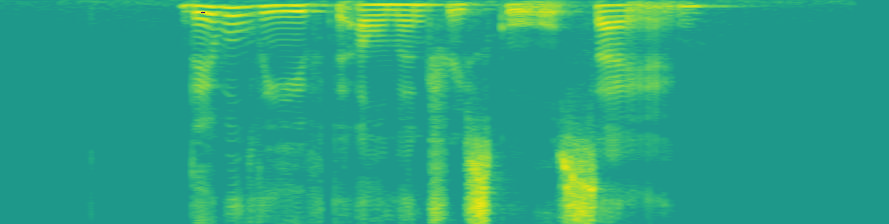

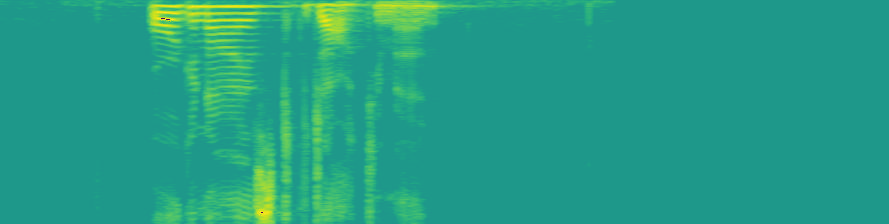

Category similar

In [11]:
sd = SiameseDataset.from_label_list(audios.train, [0, 1], open_args=tfm_params)
sd.train.x.tfm_args = tfm_params
sd.valid.x.tfm_args = tfm_params
data = sd.databunch(bs=1)
learn = Learner(data, SiameseResnet(), metrics=accuracy)
x, y = data.train_ds[0]
x.show()


- Model needs to be able to infer one data through the model